## Preliminaries: loading python packages
We will use a popular Machine Learning library called SciKit-Learn (sklearn for short) to build a prediction model of drug success in Python. 

This example jupyter notebook will show you how to load the Open Targets data using the pandas library, inspect and transform the data and then create a type of ensemble learning method called Random Forests classifier on a subset of selected features.


In [2]:
import os
import logging
import pandas as pd
import math
import numpy as np
import sklearn
# check correlation
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy.stats import spearmanr, pearsonr
# for plotting result (works with pandas)
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
# for pretty formatting of results
from tabulate import tabulate
# random forest classifier
from sklearn.datasets import make_blobs
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#from settings import Config

def random_forest_classifier(features, target):
    clf = RandomForestClassifier()
    clf.fit(features, target)
    return clf

def split_dataset(dataset, train_percentage, feature_headers, target_header):
    # Split dataset into train and test dataset
    train_x, test_x, train_y, test_y = train_test_split(dataset[feature_headers], dataset[target_header],
                                                        train_size=train_percentage)
    return train_x, test_x, train_y, test_y



/Users/otvisitor/virtual_envs/evidence_generation/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/otvisitor/virtual_envs/evidence_generation/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Load the Open Targets data
We load the Open Targets scores for the association between genes and diseases.

We also load the gene features that we will encode as integer to build the prediction model.

In the following code, we will assume that you have already downloaded the data to your computer.
If not, please refer to the [Wiki page](https://github.com/opentargets/biodatawest_hackathon/wiki/Open-Targets-hackathon-datasets-description) on the github repository.

The Open Targets dataset contains 2,3M rows. 

In [3]:
# load all the associations between gene and diseases from Open Targets
HOME_DIR = os.environ['HOME']
input_ot_scores=os.path.join(os.path.sep, HOME_DIR, 'gene_disease_associations_with_expression.csv.gz')
df = pd.read_csv(input_ot_scores)

# load gene info
gene_info=os.path.join(os.path.sep, HOME_DIR, 'gene_info.csv')
gene_df = pd.read_csv(gene_info)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2405593 entries, 0 to 2405592
Data columns (total 38 columns):
target_indication      object
entrez_id              float64
ensembl_gene_id        object
symbol                 object
disease_id             object
disease_label          object
therapeutic_area       object
is_direct              bool
overall_score          float64
genetic_association    float64
somatic_mutation       float64
known_drug             float64
rna_expression         float64
affected_pathway       float64
animal_model           float64
literature             float64
expression_atlas       float64
uniprot                float64
gwas_catalog           float64
phewas_catalog         float64
eva                    float64
uniprot_literature     float64
genomics_england       float64
gene2phenotype         float64
reactome               float64
slapenrich             float64
progeny                float64
phenodigm              float64
cancer_gene_census     float

## First glance at the data
In the following, we look at the top five rows, summary statistics and score distribution of the Open Targets dataset.
The first column of the data frame called `target_indication` is the key for the association between a gene and a disease (also called indication because some drugs are indicated for specific disease conditions).

The `disease_id` column is a disease ontology identifier whose name is encoded in the `disease_label` column. Each disease is classified in the Experimental Factor Ontology (EFO) and we have indicated what therapeutic area(s) it belongs to in the `therapeutic_area` column. 

The flag `is_direct` indicates whether the evidence linking a gene to an indication was directly extracted from one of the datasources that was ingested in Open Targets or whether this information was propagated along the ontology direct acyclic graph (DAG). As an example, Ulcerative Colitis and Crohn's disease are considered subtypes of Inflammatory Bowel Disease (IBD). Hence, a direct evidence linking a protein-coding gene to Ulcerative Colitis is propagated to IBD as an indirect evidence. This bottom-up approach leads to higher categories that are currently defined as therapeutic areas. For instance, IBD is in the digestive system disease therapeutic area as well as in the immune system disease therapeutic area.

The `overall_score` informs us about the information content linking a gene to a disease. The higher it is, the more likely there is an association (not direct correlation) between the two.

This `overall_score` is broken down by datatype (genetics association, somatic mutations when relevant, known drugs, affected pathways, RNA expression, text-mining, animal models).
In turn, the score for a datatype results from scoring each individual piece of evidence from a datasource.

For more details, please read the article we published in NAR Database a few years ago.

Open Targets: a platform for therapeutic target identification and validation
Nucleic Acids Research, Volume 45, Issue D1, 4 January 2017, Pages D985–D994, 
https://doi.org/10.1093/nar/gkw1055


In [4]:
# View the top 5 rows
df.head()

,target_indication,entrez_id,ensembl_gene_id,symbol,disease_id,disease_label,therapeutic_area,is_direct,overall_score,genetic_association,...,cancer_gene_census,eva_somatic,uniprot_somatic,intogen,chembl,europepmc,tissue_label,source,max_fold_change,expression_score
0,ENSG00000065485-Orphanet_3389,10954.0,ENSG00000065485,PDIA5,Orphanet_3389,Tuberculosis,infectious disease,True,0.000058,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,Unspecified,Unspecified,0.0,0.0
1,ENSG00000145431-HP_0001392,56034.0,ENSG00000145431,PDGFC,HP_0001392,Abnormality of the liver,phenotype,False,0.038028,0.0,...,0.0,0.0,0.0,0.0,0.0,0.038028,Unspecified,Unspecified,0.0,0.0
2,ENSG00000113231-EFO_0000546,8622.0,ENSG00000113231,PDE8B,EFO_0000546,injury,other disease,True,0.200000,0.0,...,0.0,0.0,0.0,0.0,0.2,0.000000,Unspecified,Unspecified,0.0,0.0
3,ENSG00000163114-Orphanet_98497,5161.0,ENSG00000163114,PDHA2,Orphanet_98497,Genetic peripheral neuropathy,genetic disorder,False,0.034317,0.0,...,0.0,0.0,0.0,0.0,0.0,0.034317,Unspecified,Unspecified,0.0,0.0
4,ENSG00000160613-HP_0000707,9159.0,ENSG00000160613,PCSK7,HP_0000707,abnormality of the nervous system,phenotype,False,0.028067,0.0,...,0.0,0.0,0.0,0.0,0.0,0.028067,Unspecified,Unspecified,0.0,0.0


In [5]:
# look at the data (statistics)
print(df.describe())

          entrez_id  overall_score  genetic_association  somatic_mutation  \
count  2.369608e+06   2.405593e+06         2.405593e+06      2.405593e+06   
mean   3.218646e+05   1.662454e-01         5.892853e-02      1.467420e-02   
std    5.339287e+06   2.822572e-01         2.307051e-01      8.625464e-02   
min    1.000000e+00   1.420000e-08         0.000000e+00      0.000000e+00   
25%    2.957000e+03   1.615400e-02         0.000000e+00      0.000000e+00   
50%    6.888000e+03   4.266389e-02         0.000000e+00      0.000000e+00   
75%    5.084000e+04   1.770866e-01         0.000000e+00      0.000000e+00   
max    1.097035e+08   1.565144e+00         1.494038e+00      1.272804e+00   

         known_drug  rna_expression  affected_pathway  animal_model  \
count  2.405593e+06    2.405593e+06      2.405593e+06  2.405593e+06   
mean   2.559566e-02    2.412807e-04      2.558507e-02  2.841359e-02   
std    1.420940e-01    2.152659e-03      1.261005e-01  6.563096e-02   
min    0.000000e+00   

## Plot the distribution of Open Targets scores across datatypes

### For all associations
The first treillis shows the distribution of scores for direct and indirect associations

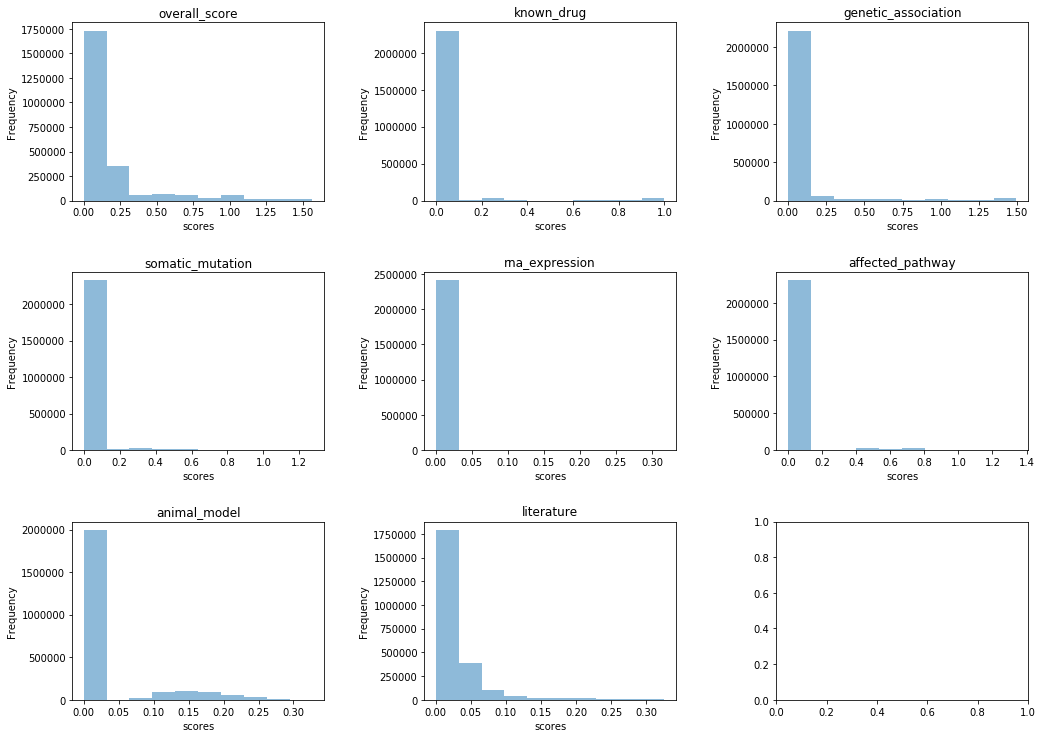

In [6]:
score_attributes = ['overall_score', 'known_drug','genetic_association', 'somatic_mutation', 'rna_expression', 'affected_pathway', 'animal_model', 'literature']
ncols = 3
nrows = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(14,10))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust( wspace = 0.4, hspace = 0.4 )
for index, item in enumerate(score_attributes):
    posx = int(index/nrows)
    posy = index % ncols
    df[item].plot.hist(alpha=0.5, ax=axes[posx,posy], title=item)
    axes[posx,posy].set(xlabel="scores", ylabel="Frequency")

### For direct associations only
The second treillis shows the distribution of scores for direct associations only

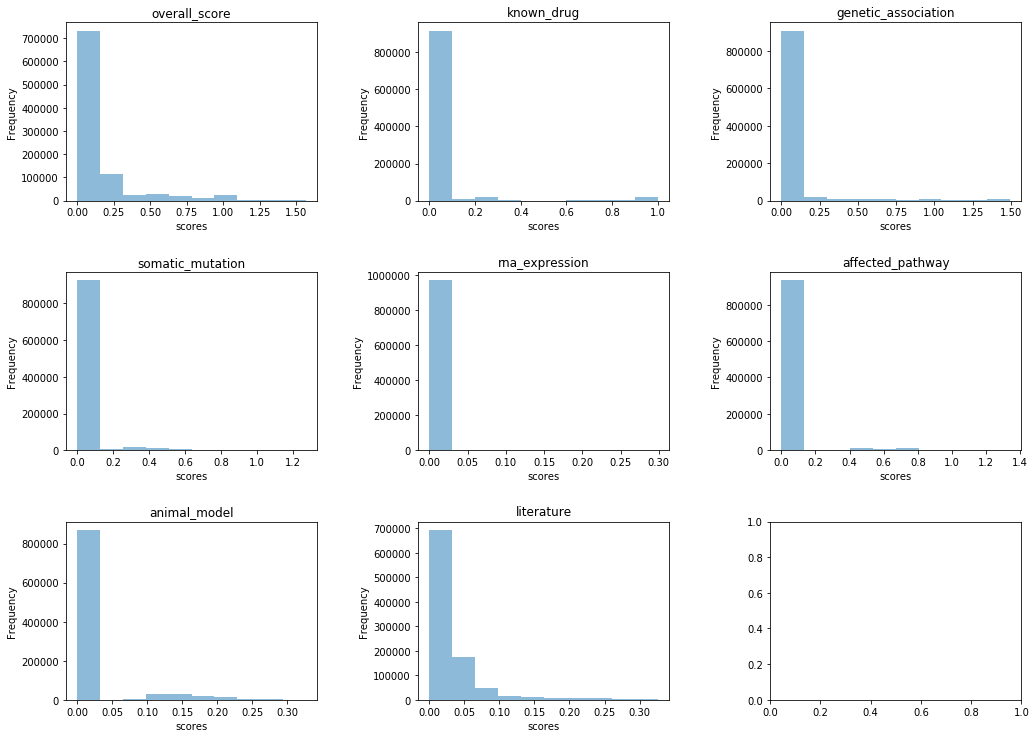

In [10]:
score_attributes = ['overall_score', 'known_drug','genetic_association', 'somatic_mutation', 'rna_expression', 'affected_pathway', 'animal_model', 'literature']
ncols = 3
nrows = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(14,10))
fig.tight_layout()
plt.subplots_adjust( wspace = 0.4, hspace = 0.4 )
for index, item in enumerate(score_attributes):
    posx = int(index/nrows)
    posy = index % ncols
    df[df['is_direct']][item].plot.hist(alpha=0.5, ax=axes[posx,posy], title=item)
    axes[posx,posy].set(xlabel="scores", ylabel="Frequency")

### Looking for correlations in the data

We can compute a standard correlation coefficient between each pair of numerical scores we are interested in.
We can also use the `scatter_matrix` function to plot every numerical score against every other numerical score.

In [7]:
direct_df = df[df['is_direct']]
direct_df[score_attributes].corr()

,overall_score,known_drug,genetic_association,somatic_mutation,rna_expression,affected_pathway,animal_model,literature
overall_score,1.000000,0.542508,0.635165,0.336818,0.036989,0.429919,0.105819,0.193211
known_drug,0.542508,1.000000,-0.012108,0.018964,0.005904,0.043275,-0.049231,0.007089
genetic_association,0.635165,-0.012108,1.000000,0.030819,0.001678,0.037813,0.033581,0.060898
somatic_mutation,0.336818,0.018964,0.030819,1.000000,0.010016,0.142218,-0.046960,0.096994
rna_expression,0.036989,0.005904,0.001678,0.010016,1.000000,0.080498,-0.020718,0.108047
affected_pathway,0.429919,0.043275,0.037813,0.142218,0.080498,1.000000,-0.036295,0.196697
animal_model,0.105819,-0.049231,0.033581,-0.046960,-0.020718,-0.036295,1.000000,-0.140284
literature,0.193211,0.007089,0.060898,0.096994,0.108047,0.196697,-0.140284,1.000000


In [ ]:
# the following might take a long time
# hence the comments
#scatter_matrix(direct_df[score_attributes])
#, figsize=(14,10))

According to the correlation coefficients, there is almost no correlation between `genetic_association` and `known_drug`. We will investigate this further below by building a model of prediction of success of drug development.

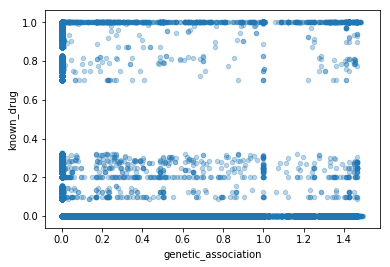

In [8]:
direct_df.plot(kind="scatter", x="genetic_association", y="known_drug", alpha=0.3)

### How to select the rows with genetic and known drug associations

In the example below, we select some of the data based on several criteria:
* `genetic_association` score > 0.0
* `known_drug` score > 0.0
* we will keep only direct evidence
* `overall_score` > THRESHOLD
* `therapeutic_area` limited to "nervous system disease"
* we will look for "Alzheimer's disease"

In [9]:
# Look at the associations with genetic evidence
THRESHOLD = 0.8
cond1 = \
    (df['genetic_association'] > 0.0) & \
    (df['known_drug'] > 0.0) & \
    (df['is_direct']) & \
    (df['overall_score'] > THRESHOLD) & \
    (df['therapeutic_area'] == 'nervous system disease') & \
    (df['disease_label'] == 'Alzheimers disease')
df[cond1].head()

,target_indication,entrez_id,ensembl_gene_id,symbol,disease_id,disease_label,therapeutic_area,is_direct,overall_score,genetic_association,...,cancer_gene_census,eva_somatic,uniprot_somatic,intogen,chembl,europepmc,tissue_label,source,max_fold_change,expression_score
257677,ENSG00000172572-EFO_0000249,5139.0,ENSG00000172572,PDE3A,EFO_0000249,Alzheimers disease,nervous system disease,True,1.001141,0.004566,...,0.0,0.0,0.0,0.0,1.0,0.000000,Unspecified,Unspecified,0.0,0.0
478277,ENSG00000080815-EFO_0000249,5663.0,ENSG00000080815,PSEN1,EFO_0000249,Alzheimers disease,nervous system disease,True,1.466226,1.421608,...,0.0,0.0,0.0,0.0,1.0,0.140286,Unspecified,Unspecified,0.0,0.0
550960,ENSG00000185313-EFO_0000249,6336.0,ENSG00000185313,SCN10A,EFO_0000249,Alzheimers disease,nervous system disease,True,1.000115,0.000460,...,0.0,0.0,0.0,0.0,1.0,0.000000,Unspecified,Unspecified,0.0,0.0
771913,ENSG00000142192-EFO_0000249,351.0,ENSG00000142192,APP,EFO_0000249,Alzheimers disease,nervous system disease,True,1.487739,1.409832,...,0.0,0.0,0.0,0.0,1.0,0.121213,Unspecified,Unspecified,0.0,0.0
779077,ENSG00000006283-EFO_0000249,8913.0,ENSG00000006283,CACNA1G,EFO_0000249,Alzheimers disease,nervous system disease,True,1.005908,0.023634,...,0.0,0.0,0.0,0.0,1.0,0.000000,Unspecified,Unspecified,0.0,0.0


## Binning the data

After looking at the distribution of known_drug scores, we will bin these scores into 3 bins:
* low (score<=0.3)
* medium (0.3<score<=0.7)
* high (score>0.7)

This is one way to do it. With skLearn you can do the same with one command.

In [10]:
# df.groupby(pd.cut(df['percentage'], bins=bins)).size()
b=df['known_drug'].values
print(type(b))
pd.cut(b, 4, labels=["verylow", "low", "medium", "high"])[:10]
# custom bucket area for drugs
bins = np.array([ -0.0, 0.3, 0.7, 2.0 ])
labels = [1,2,3]
df['known_drug_binned'] = np.searchsorted(bins, df['known_drug'].values)
print(df.groupby(np.searchsorted(bins, df['known_drug'].values)).size())
# that's an alternative way to do it
#df['known_drug_binned2'] = pd.cut(df['known_drug'], bins=bins, labels=False)
#print(pd.cut(df['known_drug'], bins=bins, labels=False))
#print(df.groupby(pd.cut(df['known_drug'], bins=bins)).size())
#categories = df['known_drug_binned'].cat.categories
#print(categories)

<class 'numpy.ndarray'>
0    2294187
1      55280
2       7718
3      48408
dtype: int64


## Filtering the data

Then, we will filter data to exclude any association that were propagated based on the disease classification.
We keep the association with the value `is_direct==True` and with a drug score > 0.
`known_drug_binned` will be the variable we want to predict.

57414


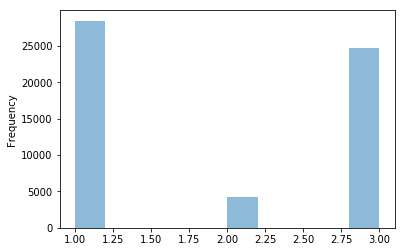

In [11]:
# get the data where is_direct is true and where there is some DRUG information ('known_drug')

cond1 = (df['known_drug'] > 0.0) & (df['is_direct'])
df_known_drug = df[cond1]

# 57,414 elements
print(len(df_known_drug))
# plot distribution of series
df_known_drug['known_drug_binned'].plot.hist(alpha=0.5)

## Add gene features

In this section, we select gene attributes we would like to add to our prediction model. They are coming from the second dataset we have loaded. We have selected a few rows to see what the file contains.

In [12]:
gene_features = ['protein_class', 'locus_group', 'target_class', 'topology_type', 'target_location']
gene_feature_default_value = dict(
    protein_class = 'Unclassified protein',
    locus_group='other', 
    target_class='Other',
    topology_type='Unknown', 
    target_location='Unknown'
)

# check a few entries with some GO 
gene_df.fillna({x:gene_feature_default_value[x] for x in gene_features}, inplace=True)

gene_df[gene_df['go_id'].notnull() & gene_df['protein_class'].notnull() & gene_df['GTEX_median_all_tissues'] > 0.0].head()

,Unnamed: 0,symbol,hgnc_id,ensembl_gene_id,entrez_id,uniprot_id,locus_type,locus_group,go_id,go_label,evidence_type,reported_count,protein_class,target_class,topology_type,target_location,ExAC_LoF,pc_mouse_gene_identity,GTEX_median_all_tissues,description
60,60,TCIRG1,HGNC:11647,ENSG00000110719,10312.0,Q13488,gene with protein product,protein-coding gene,GO:0006968,cellular defense response,TAS,1.0,Unclassified protein,Transporter,MultiTM,Exposed,Unclassified,80.3357,52.74,"T cell immune regulator 1, ATPase H+ transport..."
61,61,TCIRG1,HGNC:11647,ENSG00000110719,10312.0,Q13488,gene with protein product,protein-coding gene,GO:0046961,"proton-transporting ATPase activity, rotationa...",IBA,1.0,Unclassified protein,Transporter,MultiTM,Exposed,Unclassified,80.3357,52.74,"T cell immune regulator 1, ATPase H+ transport..."
62,62,TCIRG1,HGNC:11647,ENSG00000110719,10312.0,Q13488,gene with protein product,protein-coding gene,GO:0016236,macroautophagy,ISS,1.0,Unclassified protein,Transporter,MultiTM,Exposed,Unclassified,80.3357,52.74,"T cell immune regulator 1, ATPase H+ transport..."
63,63,TCIRG1,HGNC:11647,ENSG00000110719,10312.0,Q13488,gene with protein product,protein-coding gene,GO:0101003,ficolin-1-rich granule membrane,TAS,1.0,Unclassified protein,Transporter,MultiTM,Exposed,Unclassified,80.3357,52.74,"T cell immune regulator 1, ATPase H+ transport..."
64,64,TCIRG1,HGNC:11647,ENSG00000110719,10312.0,Q13488,gene with protein product,protein-coding gene,GO:0000220,"vacuolar proton-transporting V-type ATPase, V0...",IEA,1.0,Unclassified protein,Transporter,MultiTM,Exposed,Unclassified,80.3357,52.74,"T cell immune regulator 1, ATPase H+ transport..."


## Subselect the gene attributes we need to build the prediction model

In the following, we select the gene attributes we are interested in. We discarded `protein_class` because there were too many distinct attributes.

In [13]:
# subselect the features we need for the training
gene_features = ['locus_group', 'target_class', 'topology_type', 'target_location']
gene_feature_map = dict()

series = ['ensembl_gene_id']
series.extend(gene_features)
print(series)

# subselect and drop duplicates
gene_pred_df = gene_df[series].drop_duplicates()
print(len(gene_pred_df))

['ensembl_gene_id', 'locus_group', 'target_class', 'topology_type', 'target_location']
36788


In [14]:
# remove duplicates (we keep only one label per feature for any gene)
# there might be some genes with contradictory information
# e.g. RNVU1-8, RNA, variant U1 small nuclear 8 (ENSG00000201142)
for gene_feature in gene_features:
    column_name = gene_feature
    group = gene_pred_df.groupby('ensembl_gene_id')[column_name].unique()
    r = group[group.apply(lambda x: len(x)>1)]
    for ensembl_gene_id, v in r.items():
        mask = gene_pred_df.ensembl_gene_id == ensembl_gene_id
        gene_pred_df.loc[mask, column_name] = v[0]
    gene_pred_df = gene_pred_df.drop_duplicates()
    print(len(gene_pred_df))

36787
36785
36785
36776


In [17]:
# get the distinct values of features as a list
for gene_feature in gene_features:
    l = gene_pred_df[gene_feature].drop_duplicates().tolist()
    gene_feature_map[gene_feature] = l
    print(l)

['non-coding RNA', 'other', 'protein-coding gene', 'pseudogene', 'phenotype']
['Other', 'Extracellular_all_others', 'Transporter', 'Enzyme_all_others', 'Enzyme_Transferase', '7TM_all_others', 'Transcriptional_Factor_all_others', 'Extracellular Ligand', 'Protease', 'Receptor_all_others', 'Not Characterized', 'Kinase_Protein', 'Nuclear Receptor', 'Enzyme_Esterase', 'Ion Channel', '7TM_Group1']
['Unknown', 'Secreted', 'MultiTM', 'Unattached', 'Membrane', 'SingleTM']
['Unknown', 'Free', 'Exposed', 'Cytoplasm', 'Organelle', 'Mitochondrion', 'Nucleus']


In [18]:
# We add the gene features to the df_chembl dataframe
print(len(df_known_drug))
df_known_drug_features = pd.merge(df_known_drug, gene_pred_df, how='left', on=['ensembl_gene_id'])
print(len(df_known_drug_features))
df_known_drug_features.fillna({x:gene_feature_default_value[x] for x in gene_features}, inplace=True)
print(len(df_known_drug_features))
df_known_drug_features.head()

57414
57414
57414


,target_indication,entrez_id,ensembl_gene_id,symbol,disease_id,disease_label,therapeutic_area,is_direct,overall_score,genetic_association,...,europepmc,tissue_label,source,max_fold_change,expression_score,known_drug_binned,locus_group,target_class,topology_type,target_location
0,ENSG00000113231-EFO_0000546,8622.0,ENSG00000113231,PDE8B,EFO_0000546,injury,other disease,True,0.200000,0.0,...,0.0000,Unspecified,Unspecified,0.0,0.0,1,protein-coding gene,Enzyme_Esterase,Unattached,Cytoplasm
1,ENSG00000160191-EFO_0000712,5152.0,ENSG00000160191,PDE9A,EFO_0000712,stroke,cardiovascular disease; other disease,True,1.000000,0.0,...,0.0000,Unspecified,Unspecified,0.0,0.0,3,protein-coding gene,Enzyme_Esterase,Unattached,Organelle
2,ENSG00000073417-EFO_0001360,5151.0,ENSG00000073417,PDE8A,EFO_0001360,type II diabetes mellitus,metabolic disease,True,1.000000,0.0,...,0.0000,Unspecified,Unspecified,0.0,0.0,3,protein-coding gene,Enzyme_Esterase,Unattached,Cytoplasm
3,ENSG00000185527-EFO_0006890,5148.0,ENSG00000185527,PDE6G,EFO_0006890,fibrosis,neoplasm,True,0.284722,0.0,...,0.0000,Unspecified,Unspecified,0.0,0.0,1,protein-coding gene,Enzyme_Esterase,Unattached,Cytoplasm
4,ENSG00000154678-EFO_0000537,5137.0,ENSG00000154678,PDE1C,EFO_0000537,hypertension,cardiovascular disease,True,0.103600,0.0,...,0.0144,Unspecified,Unspecified,0.0,0.0,1,protein-coding gene,Enzyme_Esterase,Unattached,Cytoplasm


In [20]:
# encode attributes
encoded_gene_features = list()
for gene_feature in gene_features:
    cat_df = pd.get_dummies(df_known_drug_features[gene_feature],prefix=gene_feature)
    encoded_gene_features.extend(cat_df.columns.values)
    for h in list(cat_df.columns.values):
        df_known_drug_features[h] = cat_df[h]
#cat_features

## Select the therapeutic area of interest
In this example, we will train the model on 'immune system disease'.


In [21]:
# drop the overall score as we don't need it in this exercice
print(len(df_known_drug_features))
series = ['target_indication', 'genetic_association', 'somatic_mutation', 'rna_expression', 'affected_pathway', 'animal_model', 'expression_score']
series.extend(encoded_gene_features)
series.append('known_drug_binned')
print(series)

# everything
df_general_pred = df_known_drug_features[series]
headers = list(df_general_pred.columns.values)

# Let's build a model for a TA
# neoplasm for Cancer Drugs
# respiratory system disease for Asthma
# immune system disease
# 
TA = 'immune system disease'
TA_pred_cond = (df_known_drug_features['therapeutic_area'].str.contains(TA, na=False)) | (df_known_drug_features['disease_label'] == TA)
df_TA_pred = df_known_drug_features[TA_pred_cond][series]
print(len(df_TA_pred))

# TODO: we can train a model for cancer and a model for immuno-inflammation for instance.
# we can also add information about the disease
# Look at the associations with genetic evidence
#cond1 = \
#    (df_chembl_pred['genetic_association'] > 0.0) & \
#    (df_chembl_pred['target_indication'].str.startswith('ENSG00000185313', na=False))
#df_chembl_pred[cond1].head()
df_chembl_pred = df_TA_pred

57414
['target_indication', 'genetic_association', 'somatic_mutation', 'rna_expression', 'affected_pathway', 'animal_model', 'expression_score', 'locus_group_other', 'locus_group_protein-coding gene', 'locus_group_pseudogene', 'target_class_7TM_Group1', 'target_class_7TM_all_others', 'target_class_Enzyme_Esterase', 'target_class_Enzyme_Transferase', 'target_class_Enzyme_all_others', 'target_class_Extracellular Ligand', 'target_class_Extracellular_all_others', 'target_class_Ion Channel', 'target_class_Kinase_Protein', 'target_class_Nuclear Receptor', 'target_class_Other', 'target_class_Protease', 'target_class_Receptor_all_others', 'target_class_Transcriptional_Factor_all_others', 'target_class_Transporter', 'topology_type_Membrane', 'topology_type_MultiTM', 'topology_type_Secreted', 'topology_type_SingleTM', 'topology_type_Unattached', 'topology_type_Unknown', 'target_location_Cytoplasm', 'target_location_Exposed', 'target_location_Free', 'target_location_Mitochondrion', 'target_locati

In [28]:
# Split the data in train and tests (80:20)
print(headers[1:-1])
print(headers[-1])
train_x, test_x, train_y, test_y = split_dataset(df_chembl_pred, 0.8, headers[1:-1], headers[-1])

# Train and Test dataset size details
'''
print "Train_x Shape :: ", train_x.shape
print "Train_y Shape :: ", train_y.shape
print "Test_x Shape :: ", test_x.shape
print "Test_y Shape :: ", test_y.shape
'''

# Create random forest classifier instance
trained_model = random_forest_classifier(train_x, train_y)
print("Trained model :: ", trained_model)

predictions = trained_model.predict(test_x)


['genetic_association', 'somatic_mutation', 'rna_expression', 'affected_pathway', 'animal_model', 'expression_score', 'locus_group_other', 'locus_group_protein-coding gene', 'locus_group_pseudogene', 'target_class_7TM_Group1', 'target_class_7TM_all_others', 'target_class_Enzyme_Esterase', 'target_class_Enzyme_Transferase', 'target_class_Enzyme_all_others', 'target_class_Extracellular Ligand', 'target_class_Extracellular_all_others', 'target_class_Ion Channel', 'target_class_Kinase_Protein', 'target_class_Nuclear Receptor', 'target_class_Other', 'target_class_Protease', 'target_class_Receptor_all_others', 'target_class_Transcriptional_Factor_all_others', 'target_class_Transporter', 'topology_type_Membrane', 'topology_type_MultiTM', 'topology_type_Secreted', 'topology_type_SingleTM', 'topology_type_Unattached', 'topology_type_Unknown', 'target_location_Cytoplasm', 'target_location_Exposed', 'target_location_Free', 'target_location_Mitochondrion', 'target_location_Nucleus', 'target_locati

/Users/otvisitor/virtual_envs/evidence_generation/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/otvisitor/virtual_envs/evidence_generation/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [29]:
# use xrange for python 2.7 code
for i in range(0, 20):
    print("Actual outcome :: ", list(test_y)[i], " and Predicted outcome :: ", predictions[i])

print("Train Accuracy :: ", accuracy_score(train_y, trained_model.predict(train_x)))
print("Test Accuracy  :: ", accuracy_score(test_y, predictions))

Actual outcome ::  1  and Predicted outcome ::  3
Actual outcome ::  2  and Predicted outcome ::  1
Actual outcome ::  3  and Predicted outcome ::  3
Actual outcome ::  1  and Predicted outcome ::  1
Actual outcome ::  1  and Predicted outcome ::  1
Actual outcome ::  1  and Predicted outcome ::  1
Actual outcome ::  3  and Predicted outcome ::  2
Actual outcome ::  1  and Predicted outcome ::  1
Actual outcome ::  3  and Predicted outcome ::  3
Actual outcome ::  1  and Predicted outcome ::  1
Actual outcome ::  3  and Predicted outcome ::  1
Actual outcome ::  1  and Predicted outcome ::  3
Actual outcome ::  1  and Predicted outcome ::  1
Actual outcome ::  3  and Predicted outcome ::  1
Actual outcome ::  3  and Predicted outcome ::  1
Actual outcome ::  2  and Predicted outcome ::  1
Actual outcome ::  3  and Predicted outcome ::  2
Actual outcome ::  1  and Predicted outcome ::  1
Actual outcome ::  3  and Predicted outcome ::  1
Actual outcome ::  3  and Predicted outcome ::  1


## Create a confusion matrix
The [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) is a way of tabulating the number of misclassifications, i.e., the number of predicted classes which ended up in a wrong classification bin based on the true classes.

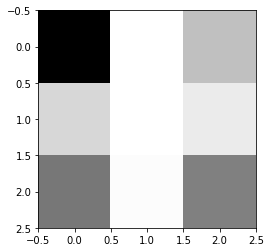

In [30]:
conf = confusion_matrix(test_y, predictions)
plt.imshow(conf, cmap='binary', interpolation='None')
plt.show()

While sklearn.metrics.confusion_matrix provides a numeric matrix, it can be more useful to generate a 'report' using the following (https://stats.stackexchange.com/questions/95209/how-can-i-interpret-sklearn-confusion-matrix)

In [31]:
pd.crosstab(test_y, predictions, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,1,2,3,All
True,,,,
1,259,0,64,323
2,41,1,21,63
3,138,4,129,271
All,438,5,214,657


In [32]:
test_score = r2_score(test_y, predictions)
spearman = spearmanr(test_y, predictions)
pearson = pearsonr(test_y, predictions)
print('Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print('Test data R-2 score: {test_score:>5.3}')
print('Test data Spearman correlation: {spearman[0]:.3}')
print('Test data Pearson correlation: {pearson[0]:.3}')

Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}
Test data R-2 score: {test_score:>5.3}
Test data Spearman correlation: {spearman[0]:.3}
Test data Pearson correlation: {pearson[0]:.3}


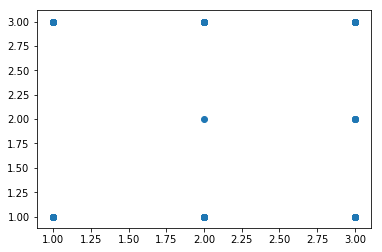

In [33]:
plt.scatter(test_y, predictions)
plt.show()

## How to inspect the importance of every feature in Random Forests classifier
With random forests we can get how important each feature was in classifying. In this case, we can see that `genetic_association` was more important in classification than (baseline and differential) RNA expression.

In [34]:
# inspect the importance of every feature in a random forest. 
headers = ["name", "score"]
values = sorted(zip(train_x.columns, trained_model.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(values, headers, tablefmt="plain"))

name                                                  score
genetic_association                             0.159558
rna_expression                                  0.159044
expression_score                                0.102634
target_location_Mitochondrion                   0.0700095
target_class_Enzyme_all_others                  0.04354
target_class_Nuclear Receptor                   0.0386899
target_location_Nucleus                         0.035329
target_class_Protease                           0.0271527
target_location_Organelle                       0.0267814
target_class_Enzyme_Transferase                 0.0253737
target_class_Other                              0.0246084
target_class_Enzyme_Esterase                    0.0236743
topology_type_MultiTM                           0.0235707
topology_type_Secreted                          0.0223115
target_class_Kinase_Protein                     0.0214937
target_location_Cytoplasm                       0.0205857
topology_type_Unat